# includes

In [1]:
from ctypes import *
import math
import random
import os

In [2]:
import sys

In [3]:
import numpy as np
import cv2

# my util functions

In [22]:
from matplotlib import pyplot as plt
from enum import Enum
from IPython import display
%matplotlib inline

class ColorMode(Enum):
    RGB  = 0
    BGR  = 1
    Gray = 2
    RAW  = 3

def show(images, size=(16, 10), color_modes=ColorMode.RGB, subplots=None, title=None, no_axis=False):
        
    if not isinstance(images, list):
        images = [images]
        
    l = len(images)
    
    if not isinstance(color_modes, list):
        color_modes = [color_modes] * l
        
    titles = title
    if not isinstance(titles, list):
        titles = [titles] * l
    
    if subplots is None:
        subplots = {'rows': math.ceil(l / 2), 'cols': 2}    
    elif 'rows' in subplots and 'cols' not in subplots:
        subplots['cols'] = math.ceil(l / subplots['rows'])        
    else:
        subplots['rows'] = math.ceil(l / subplots['cols'])        

    if isinstance(size, list) or isinstance(size, tuple):
        plt.figure(figsize=(size[0], size[1]))    
    else:
        plt.figure(figsize=(size, size))
    
       
    # plot images:
    for i, image in enumerate(images):
        if len(images) > 1:
            plt.subplot(subplots['rows'], subplots['cols'], i + 1)
        
        title = titles[i]        
        if title is not None:
            plt.title(title)
            
        color_mode = color_modes[i]
        
        if color_mode == ColorMode.RAW:
            plt.imshow(image)            
        else:
            img = image.copy()
            if img.dtype != np.uint8:
                img = np.interp(img, (img.min(), img.max()), (0, 255)).astype(np.uint8)   
            if color_mode == ColorMode.Gray:                
                if img.ndim > 2:
                    img = cv2.cvtColor(img[..., :3], cv2.COLOR_BGR2GRAY) if img.shape[2] >= 3 else img[..., 0]
                plt.imshow(img, cmap=plt.cm.gray)
            elif color_mode == ColorMode.BGR:
                plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            else:
                plt.imshow(img)

        if no_axis:
            plt.axis('off')
            plt.axis('tight')  
            plt.axis('image')
        
    plt.show()


# darknet util functions

In [39]:
class BOX(Structure):
    _fields_ = [("x", c_float),
                ("y", c_float),
                ("w", c_float),
                ("h", c_float)]


class DETECTION(Structure):
    _fields_ = [("bbox", BOX),
                ("classes", c_int),
                ("prob", POINTER(c_float)),
                ("mask", POINTER(c_float)),
                ("objectness", c_float),
                ("sort_class", c_int),
                ("uc", POINTER(c_float)),
                ("points", c_int),
                ("embeddings", POINTER(c_float)),
                ("embedding_size", c_int),
                ("sim", c_float),
                ("track_id", c_int)]

class DETNUMPAIR(Structure):
    _fields_ = [("num", c_int),
                ("dets", POINTER(DETECTION))]


class IMAGE(Structure):
    _fields_ = [("w", c_int),
                ("h", c_int),
                ("c", c_int),
                ("data", POINTER(c_float))]


class METADATA(Structure):
    _fields_ = [("classes", c_int),
                ("names", POINTER(c_char_p))]


def network_width(net):
    return lib.network_width(net)


def network_height(net):
    return lib.network_height(net)


def bbox2points(bbox):
    """
    From bounding box yolo format
    to corner points cv2 rectangle
    """
    x, y, w, h = bbox
    xmin = int(round(x - (w / 2)))
    xmax = int(round(x + (w / 2)))
    ymin = int(round(y - (h / 2)))
    ymax = int(round(y + (h / 2)))
    return xmin, ymin, xmax, ymax


def class_colors(names):
    """
    Create a dict with one random BGR color for each
    class name
    """
    return {name: (
        random.randint(0, 255),
        random.randint(0, 255),
        random.randint(0, 255)) for name in names}


def load_network(config_file, data_file, weights, batch_size=1):
    """
    load model description and weights from config files
    args:
        config_file (str): path to .cfg model file
        data_file (str): path to .data model file
        weights (str): path to weights
    returns:
        network: trained model
        class_names
        class_colors
    """
    network = load_net_custom(
        config_file.encode("ascii"),
        weights.encode("ascii"), 0, batch_size)
    metadata = load_meta(data_file.encode("ascii"))
    class_names = [metadata.names[i].decode("ascii") for i in range(metadata.classes)]
    colors = class_colors(class_names)
    return network, class_names, colors


def print_detections(detections, coordinates=False):
    print("\nObjects:")
    for label, confidence, bbox in detections:
        x, y, w, h = bbox
        if coordinates:
            print("{}: {}%    (left_x: {:.0f}   top_y:  {:.0f}   width:   {:.0f}   height:  {:.0f})".format(label, confidence, x, y, w, h))
        else:
            print("{}: {}%".format(label, confidence))


def draw_boxes(detections, image, colors):
    import cv2
    for label, confidence, bbox in detections:
        left, top, right, bottom = bbox2points(bbox)
        cv2.rectangle(image, (left, top), (right, bottom), colors[label], 1)
        cv2.putText(image, "{} [{:.2f}]".format(label, float(confidence)),
                    (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    colors[label], 2)
    return image


def decode_detection(detections):
    decoded = []
    for label, confidence, bbox in detections:
        confidence = str(round(confidence * 100, 2))
        decoded.append((str(label), confidence, bbox))
    return decoded


def remove_negatives(detections, class_names, num):
    """
    Remove all classes with 0% confidence within the detection
    """
    predictions = []
    for j in range(num):
        for idx, name in enumerate(class_names):
            if detections[j].prob[idx] > 0:
                bbox = detections[j].bbox
                bbox = (bbox.x, bbox.y, bbox.w, bbox.h)
                predictions.append((name, detections[j].prob[idx], (bbox)))
    return predictions

def remove_negatives_faster(detections, class_names, num):
    """
    Faster version of remove_negatives (very useful when using yolo9000)
    """
    predictions = []
    for j in range(num):
        if detections[j].best_class_idx == -1:
            continue
        name = class_names[detections[j].best_class_idx]
        bbox = detections[j].bbox
        bbox = (bbox.x, bbox.y, bbox.w, bbox.h)
        predictions.append((name, detections[j].prob[detections[j].best_class_idx], bbox))
    return predictions

# https://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
# Malisiewicz et al.
def non_max_suppression_fast(detections, overlap_thresh):
    boxes = []
    for detection in detections:
        _, _, _, (x, y, w, h) = detection
        x1 = x - w / 2
        y1 = y - h / 2
        x2 = x + w / 2
        y2 = y + h / 2
        boxes.append(np.array([x1, y1, x2, y2]))
    boxes_array = np.array(boxes)

    # initialize the list of picked indexes
    pick = []
    # grab the coordinates of the bounding boxes
    x1 = boxes_array[:, 0]
    y1 = boxes_array[:, 1]
    x2 = boxes_array[:, 2]
    y2 = boxes_array[:, 3]
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
                                               np.where(overlap > overlap_thresh)[0])))
        # return only the bounding boxes that were picked using the
        # integer data type
    return [detections[i] for i in pick]


def detect_image(network, class_names, image, thresh=.5, hier_thresh=.5, nms=.45):
    """
        Returns a list with highest confidence class and their bbox
    """
    pnum = pointer(c_int(0))
    predict_image(network, image)
    detections = get_network_boxes(network, image.w, image.h,
                                   thresh, hier_thresh, None, 0, pnum, 0)
    num = pnum[0]
    if nms:
        do_nms_sort(detections, num, len(class_names), nms)
    predictions = remove_negatives(detections, class_names, num)
    predictions = decode_detection(predictions)
    free_detections(detections, num)
    return sorted(predictions, key=lambda x: x[1])

In [6]:
def image_detection(image, network, class_names, class_colors, thresh):
    # Darknet doesn't accept numpy images.
    # Create one with image we reuse for each detect
    width = network_width(network)
    height = network_height(network)
    darknet_image = make_image(width, height, 3)
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(image_rgb, (width, height),
                               interpolation=cv2.INTER_LINEAR)

    copy_image_from_bytes(darknet_image, image_resized.tobytes())
    detections = detect_image(network, class_names, darknet_image, thresh=thresh)
    free_image(darknet_image)
    image_result = draw_boxes(detections, image_resized, class_colors)
    return cv2.cvtColor(image_result, cv2.COLOR_BGR2RGB), detections

# darknet init

In [7]:
cwd = r"D:\PROJECTS\YOLO\darknet\build\darknet\x64"

In [8]:
os.environ['PATH'] = cwd + ';' + os.environ['PATH']

In [9]:
winGPUdll = os.path.join(cwd, "darknet.dll")

In [10]:
lib = CDLL(winGPUdll, RTLD_GLOBAL)

In [11]:
lib.network_width.argtypes = [c_void_p]
lib.network_width.restype = c_int
lib.network_height.argtypes = [c_void_p]
lib.network_height.restype = c_int

In [12]:
copy_image_from_bytes = lib.copy_image_from_bytes
copy_image_from_bytes.argtypes = [IMAGE,c_char_p]

predict = lib.network_predict_ptr
predict.argtypes = [c_void_p, POINTER(c_float)]
predict.restype = POINTER(c_float)

set_gpu = lib.cuda_set_device
set_gpu.argtypes = [c_int]

init_cpu = lib.init_cpu

make_image = lib.make_image
make_image.argtypes = [c_int, c_int, c_int]
make_image.restype = IMAGE

get_network_boxes = lib.get_network_boxes
get_network_boxes.argtypes = [c_void_p, c_int, c_int, c_float, c_float, POINTER(c_int), c_int, POINTER(c_int), c_int]
get_network_boxes.restype = POINTER(DETECTION)

make_network_boxes = lib.make_network_boxes
make_network_boxes.argtypes = [c_void_p]
make_network_boxes.restype = POINTER(DETECTION)

free_detections = lib.free_detections
free_detections.argtypes = [POINTER(DETECTION), c_int]

free_batch_detections = lib.free_batch_detections
free_batch_detections.argtypes = [POINTER(DETNUMPAIR), c_int]

free_ptrs = lib.free_ptrs
free_ptrs.argtypes = [POINTER(c_void_p), c_int]

network_predict = lib.network_predict_ptr
network_predict.argtypes = [c_void_p, POINTER(c_float)]

reset_rnn = lib.reset_rnn
reset_rnn.argtypes = [c_void_p]

load_net = lib.load_network
load_net.argtypes = [c_char_p, c_char_p, c_int]
load_net.restype = c_void_p

load_net_custom = lib.load_network_custom
load_net_custom.argtypes = [c_char_p, c_char_p, c_int, c_int]
load_net_custom.restype = c_void_p

do_nms_obj = lib.do_nms_obj
do_nms_obj.argtypes = [POINTER(DETECTION), c_int, c_int, c_float]

do_nms_sort = lib.do_nms_sort
do_nms_sort.argtypes = [POINTER(DETECTION), c_int, c_int, c_float]

free_image = lib.free_image
free_image.argtypes = [IMAGE]

letterbox_image = lib.letterbox_image
letterbox_image.argtypes = [IMAGE, c_int, c_int]
letterbox_image.restype = IMAGE

load_meta = lib.get_metadata
lib.get_metadata.argtypes = [c_char_p]
lib.get_metadata.restype = METADATA

load_image = lib.load_image_color
load_image.argtypes = [c_char_p, c_int, c_int]
load_image.restype = IMAGE

rgbgr_image = lib.rgbgr_image
rgbgr_image.argtypes = [IMAGE]

predict_image = lib.network_predict_image
predict_image.argtypes = [c_void_p, IMAGE]
predict_image.restype = POINTER(c_float)

predict_image_letterbox = lib.network_predict_image_letterbox
predict_image_letterbox.argtypes = [c_void_p, IMAGE]
predict_image_letterbox.restype = POINTER(c_float)

network_predict_batch = lib.network_predict_batch
network_predict_batch.argtypes = [c_void_p, IMAGE, c_int, c_int, c_int,
                                   c_float, c_float, POINTER(c_int), c_int, c_int]
network_predict_batch.restype = POINTER(DETNUMPAIR)

# load model

In [50]:
# path to model weights:
model_path = r"E:\Models\Darknet\COCO\sport\yolov4_sport_best.weights"
data_path = r"E:\Models\Darknet\COCO\sport\sport2.data"
model_config = r"E:\Models\Darknet\COCO\sport\yolov4_sport.cfg"

In [51]:
del network, class_names

In [53]:
network, class_names, class_colors = load_network(
    model_config,
    data_path,
    model_path,
    batch_size=1
)

TypeError: 'dict' object is not callable

In [41]:
class_names

['frisbee',
 'skis',
 'snowboard',
 'sports ball',
 'kite',
 'baseball bat',
 'baseball glove',
 'skateboard',
 'surfboard',
 'tennis racket']

# load dataset

In [16]:
sys.path.append(r"D:\PROJECTS\DatasetAnnotation")
from dataset_utils.hhi_tools import *
from dataset_utils.dataset.dataset import Dataset

In [17]:
from dataset_utils.visualization.visual_tools import display_current_annotations

In [18]:
dataset = Dataset(r"E:\Datasets\coco128\train.json")

# test dataset

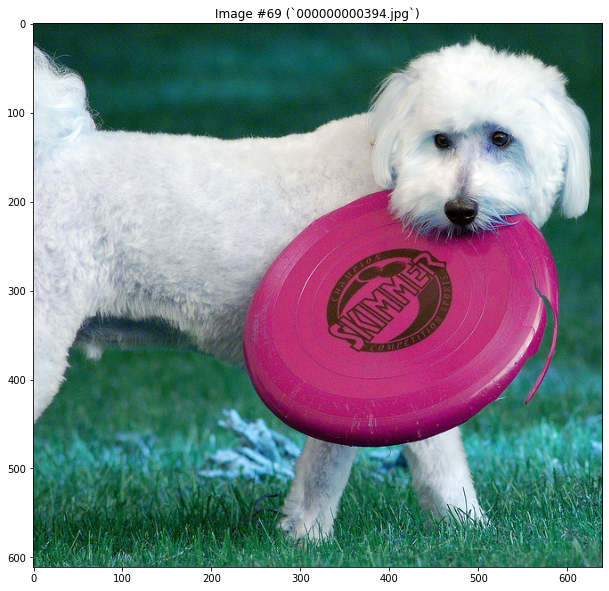

In [49]:
idx = 69 #74
# idx = 74

item_data = dataset.get_item_data(idx, source=0)
image = dataset.get_image(item_data)
image_path = dataset.get_image_path(item_data)

show(image, title=f"Image #{idx} (`{os.path.basename(image_path)}`)")

In [44]:
[a for a in dataset.unpack_annotation(item_data, rect_xywh2xyxy=False, unnormalize=False) if a['class_name'] in class_names]

[{'object': array([[0.64544499, 0.542463  , 0.55542207, 0.47788897]]),
  'class_type': 'rectangle',
  'class_id': '29',
  'uid': 'rt_b788678388_e6',
  'class_name': 'frisbee',
  'created': {'who': 'Nikita Kovalenko', 'when': '10.03.2022 - 17:26:00'}}]

Detections:
 [('frisbee', '90.08', (369.27618408203125, 339.2428283691406, 334.1068420410156, 274.74554443359375))]


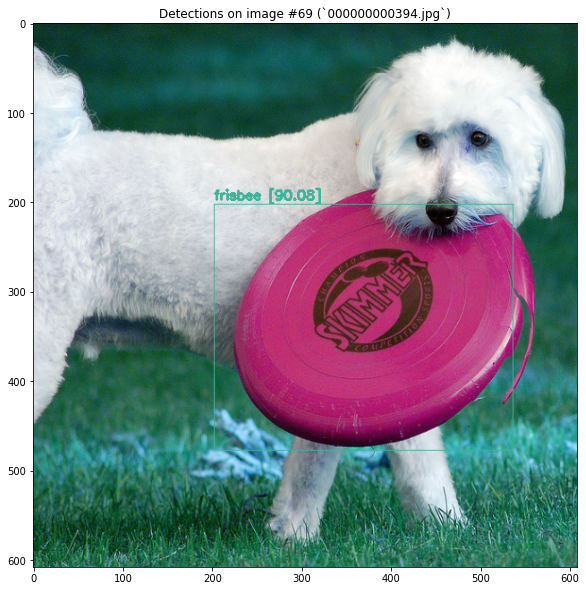

In [28]:
img, dets = image_detection(image, network, class_names, class_colors, .3)

print("Detections:\n", dets)
show(img, title=f"Detections on image #{idx} (`{os.path.basename(image_path)}`)")

# test full dataset

In [45]:
save_folder = r"E:\Models\Darknet\COCO\sport\test"

if not os.path.exists(save_folder):
    os.makedirs(save_folder)

In [48]:
for idx in range(len(dataset)):
    item_data = dataset.get_item_data(idx, source=0)    
    labels = [a for a in dataset.unpack_annotation(item_data, rect_xywh2xyxy=False, unnormalize=False) if a['class_name'] in class_names]
    
    if not len(labels):
        continue
    
    image = dataset.get_image(item_data)
    image_path = dataset.get_image_path(item_data)
    
    new_path = os.path.join(save_folder, os.path.basename(image_path))
    img, dets = image_detection(image, network, class_names, class_colors, .25)
    
    cv2.imwrite(new_path, img)
    
    show_progress_bar("Testing", idx, len(dataset))